<a href="https://colab.research.google.com/github/arybinski/xai-notebooks/blob/master/AdversialAttacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title License
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
#@title Install and Imports
!pip -q install lucid>=0.3.1

import numpy as np
import tensorflow as tf
import lucid.modelzoo.vision_models as models
from lucid.misc.io import show, load, save

# for resizing images
from PIL import Image

# for image uploader
from google.colab import files

# For plots
import matplotlib.pyplot as plt

model = models.InceptionV1()
model.load_graphdef()

In [0]:
#@title Classification function
def classify(image, n=10, show_output=True):
  im = Image.fromarray(np.uint8(image * 255.));
  im_resize = im.resize((224, 224), Image.LANCZOS)
  im_array = np.asarray(im_resize)/255.
  test_image = im_array[:,:,:3]
  tf.reset_default_graph()

  with tf.Session().as_default() as sess:
    input_t = tf.placeholder(tf.float32, shape=(224,224,3))
    model.import_graph(input_t)
    softmax2_t = sess.graph.get_tensor_by_name('import/softmax2:0')
    tf.global_variables_initializer().run()
    logits, = sess.run([softmax2_t], {input_t: test_image})
  
  BATCH = 0
  top_n_label_indices = np.argsort(logits)[BATCH][-n:][::-1]
  safe_top_n_label_indices = np.extract(top_n_label_indices < 1001, top_n_label_indices)
  top_n_labels = np.array(model.labels)[safe_top_n_label_indices]
  top_n_probs = logits[BATCH][safe_top_n_label_indices]
  max_length = max(len(label) for label in top_n_labels)
  predictions = ["{}: {: >6.2%}".format(label.rjust(max_length), prob) for (label, prob) in zip(top_n_labels, top_n_probs)]
  
  if show_output:
    show(test_image)
    print("\n".join(predictions))
  
  return (top_n_labels, top_n_probs)

  

In [0]:
#@title Composition function
def composite_img(background_img, patch_img, patch_width_ratio=0.1, patch_position=(0.0, 0.0)):
  composite = background_img.copy()
  composite_img = Image.fromarray(np.uint8(composite * 255.))
  composite_img = composite_img.resize((224, 224), Image.LANCZOS)
  composite = (np.asarray(composite_img)/255.)[:,:,:3]

  if patch_width_ratio > 0: 
    patch_img_width = int(patch_width_ratio * 224)
    patch_img_ = Image.fromarray(np.uint8(patch_img[:,:,:3] * 255.))
    patch_img_thumb = patch_img_.resize((patch_img_width, patch_img_width), Image.LANCZOS)
    patch_img_thumb_array = np.asarray(patch_img_thumb)/255.
    patch_img_thumb_size = patch_img_thumb_array.shape

    patch_y = int(patch_position[1] * (224 - patch_img_thumb_size[1]))
    patch_x = int(patch_position[0] * (224 - patch_img_thumb_size[0]))

    
    composite[patch_y:patch_y + patch_img_thumb_size[1], patch_x:patch_x + patch_img_thumb_size[0], 0:3] = patch_img_thumb_array
    
  composite_img = Image.fromarray(np.uint8(composite * 255.))
  composite_img_resize = composite_img.resize((224, 224), Image.LANCZOS)
  composite_img_resize_array = np.asarray(composite_img_resize)/255.
  return composite_img_resize_array


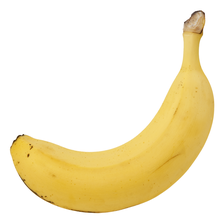

          banana: 98.28%
spaghetti squash:  0.75%
butternut squash:  0.49%
          mortar:  0.35%
    wooden spoon:  0.03%
            vase:  0.01%
           ladle:  0.01%
           lemon:  0.01%
          orange:  0.01%
     whiskey jug:  0.01%


In [77]:
#@title Classification
banana_url = "https://upload.wikimedia.org/wikipedia/commons/8/8a/Banana-Single.jpg"
background_img = load(banana_url)
_ = classify(background_img, n=10)


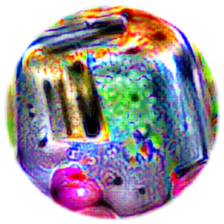

         toaster: 89.98%
      piggy bank:  6.06%
    crash helmet:  2.59%
pencil sharpener:  0.87%
         ocarina:  0.18%
            vase:  0.12%
  soap dispenser:  0.08%
          buckle:  0.01%
          maraca:  0.01%
         thimble:  0.01%


In [78]:
#@title Adversial patch
patch_img = load("https://f4.bcbits.com/img/a0745326095_16.jpg")
_ = classify(patch_img)


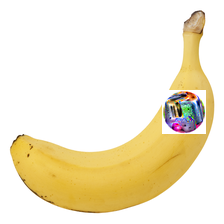

          banana: 96.79%
butternut squash:  1.33%
spaghetti squash:  0.66%
            clog:  0.35%
    wooden spoon:  0.17%
      paintbrush:  0.14%
          mortar:  0.11%
           ladle:  0.08%
     toilet seat:  0.07%
          maraca:  0.04%


In [79]:
#@title Small patch
small = composite_img(background_img, patch_img, patch_width_ratio=0.2, patch_position=(0.9, 0.5))
_ = classify(small)


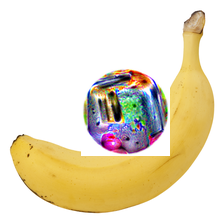

         toaster: 95.90%
         perfume:  0.91%
          banana:  0.62%
          maraca:  0.46%
spaghetti squash:  0.43%
            vase:  0.28%
      piggy bank:  0.19%
      paintbrush:  0.13%
   digital clock:  0.11%
         ocarina:  0.10%


In [80]:
#@title Bigger patch flips the top classification
medium = composite_img(background_img, patch_img, patch_width_ratio=0.4, patch_position=(0.6, 0.5))
_ = classify(medium)